In [1]:
from sklearn.metrics import accuracy_score
from detect_outlier import *
from sklearn.model_selection import train_test_split
from support_function.reporting import reporting
from support_function.evaluate import *
from support_function.labeling_from_score import labeling

In [2]:
df_normalized = read_data()
df_normalized.dropna(inplace=True)


In [3]:
X = np.array(df_normalized[
    [
        "totalAsset",
        "averageTotalAsset",
        "frequencyMountOfTransaction",
        "borrow_per_balance",
        "deposit_per_asset",
        "borrow_per_deposit",
        "totalValueOfLiquidation",
        "numberOfLiquidation",
        "frequencyOfTransaction",
        "frequencyOfDappTransactions",
        "numberOfInteractedDapps",
        "typesOfInteractedDapps",
        "numberOfReputableDapps",
        "age",
    ]
].values)
first_y = df_normalized["1st_label"].values
second_y = df_normalized["2nd_label"].values


X_train, X_test, first_y_train, first_y_test, second_y_train, second_y_test = train_test_split(
            X, first_y, second_y, test_size=0.2, stratify=second_y, random_state=40
        )
# Chuẩn bị dữ liệu

In [4]:
X_train.shape[0]

63572

In [5]:
def new_error_func(y, second_y, y_pred):
    errors = [0] * len(y_pred)
    # Lặp qua từng phần tử trong mảng
    for i in range(len(y_pred)):
        if y[i] == second_y[i]:
            errors[i] = y_pred[i] - y[i]
        else:
            min_value = min(y[i], second_y[i])
            max_value = max(y[i], second_y[i])
            if y_pred[i] <= min_value:
                errors[i] = y_pred[i] - min_value
            if y_pred[i] >= max_value:
                errors[i] = y_pred[i] - max_value
    return errors


def mean_squared_error(X, y, w):
    n = len(y)
    y_pred = labeling(np.dot(X, w))
    error = y_pred - y
    mse = np.sum(error**2) / n
    return mse


# Hàm tính gradient của hàm lỗi (MSE)
def gradient_mean_squared_error(X, y, second_y, w):
    n = len(y)
    y_pred = labeling(np.dot(X, w))
    # error = y_pred - y
    error = new_error_func(y, second_y, y_pred)
    gradient = 2 * np.dot(X.T, error) / n
    return gradient


# Gradient descent để tối ưu hóa hàm lỗi (MSE)
def stochastic_gradient_descent(
    X, y, second_y, learning_rate=0.001, num_iterations=10000, decay_rate=0.95
):
    w = np.random.uniform(0, 1, X.shape[1])
    prev_loss = float("inf")
    for i in range(num_iterations):
        random_index = np.random.randint(0, len(X))
        X_sample = X[random_index : random_index + 1]
        y_sample = y[random_index : random_index + 1]
        second_y_sample = second_y[random_index : random_index + 1]

        grad = gradient_mean_squared_error(X_sample, y_sample, second_y_sample, w)

        w -= learning_rate * grad
        learning_rate *= decay_rate  # Decay learning rate

    return w


# Áp dụng gradient descent để tối ưu hóa hàm lỗi (MSE)
learned_weights = stochastic_gradient_descent(X_train, first_y_train, second_y_train)

print("Vector trọng số tối ưu:", learned_weights)

Vector trọng số tối ưu: [ 2.11460785  2.92428793  0.14572794 -0.15072965  0.13771311 -1.69476635
  0.34393235  0.23208939  0.47033271 -0.08745456 -0.3265886   0.23918726
  0.14864333 -0.85143854]


In [6]:
max1 = 0
res = None
for i in range(100):
    learned_weights = stochastic_gradient_descent(
        X_train, first_y_train, second_y_train
    )
    pred = labeling(X_test.dot(learned_weights))
    acc = new_accuracy(first_y_test, second_y_test, pred)
    if acc > max1:
        max1 = acc
        res = learned_weights

In [7]:
predicted_labels = labeling(X_test.dot(res))
print(new_accuracy(first_y_test, second_y_test, predicted_labels))

0.38152762048571787


In [8]:
first_label = first_y_test
second_label = second_y_test
pred_label = predicted_labels

In [9]:
precision_recall(first_label, second_label, pred_label)

Precision: {1: 0.8423776662484316, 2: 0.07961399276236429, 0: 0.0978509373571102, 4: 0.06666666666666667}
Recall: {1: 0.460318820706205, 2: 0.08524378430739425, 0: 0.9771689497716894, 4: 0.0024096385542168677}
F1 Score: {1: 0.5953225448902681, 2: 0.08233276157804459, 0: 0.17788861180382376, 4: 0.004651162790697674}
Average Precision: 0.2716273157586432
Average Recall: 0.3812852983348764
Average F1 Score: 0.21504877026570854
Weighted Precision: 0.38152762048571787
Weighted Recall: 0.47136242106869036
Weighted F1 Score: 0.3049544821369656


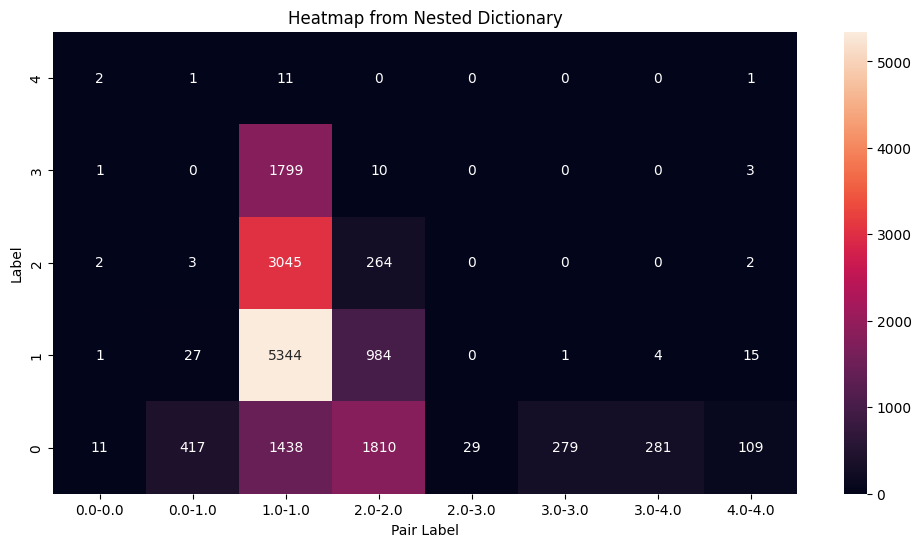

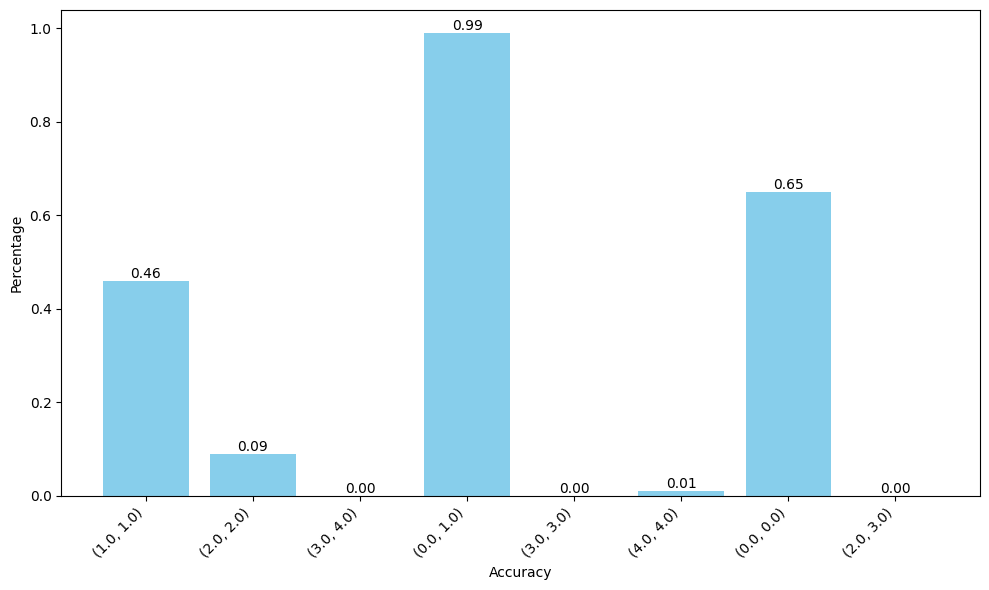

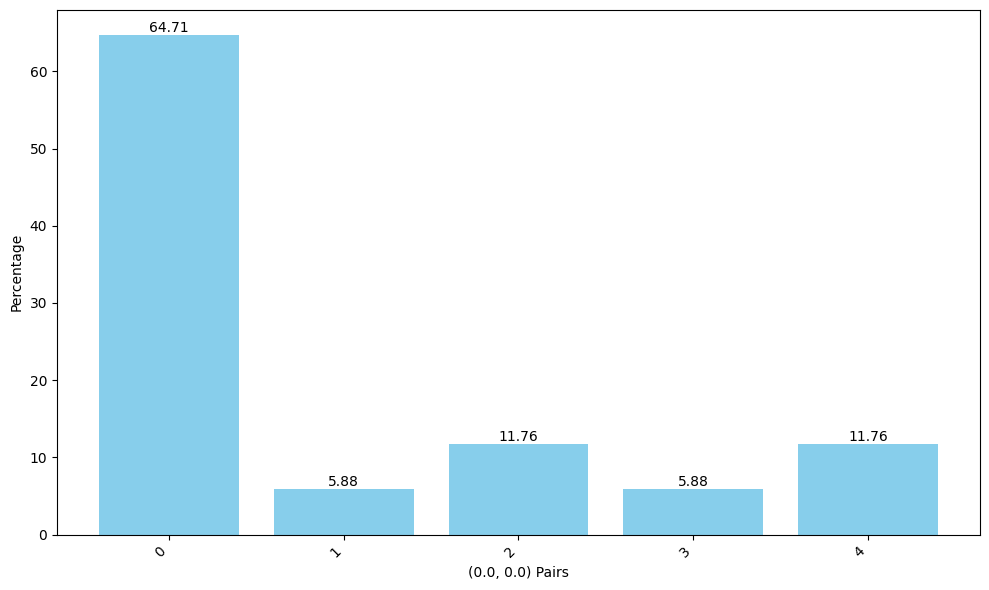

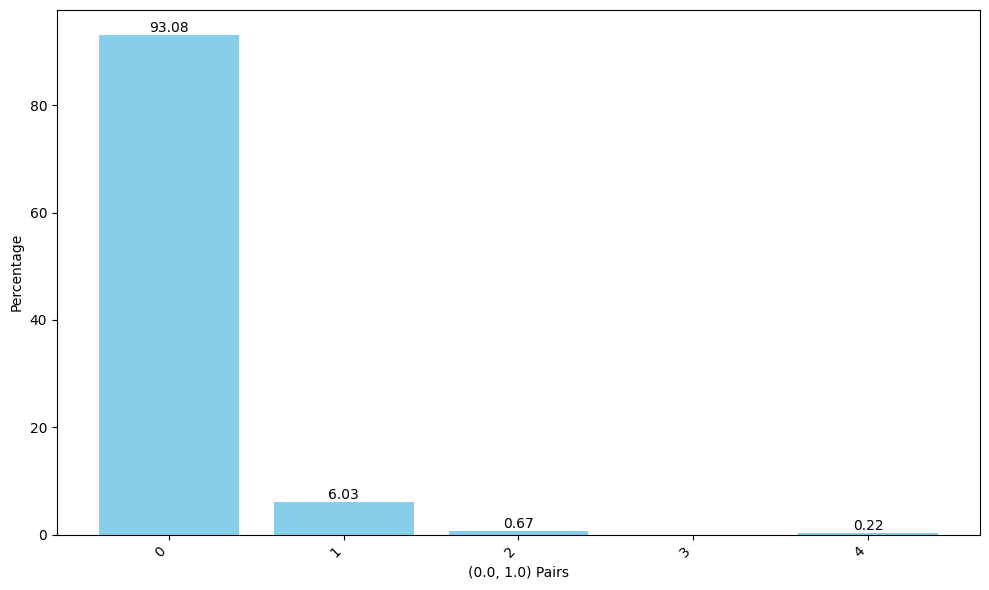

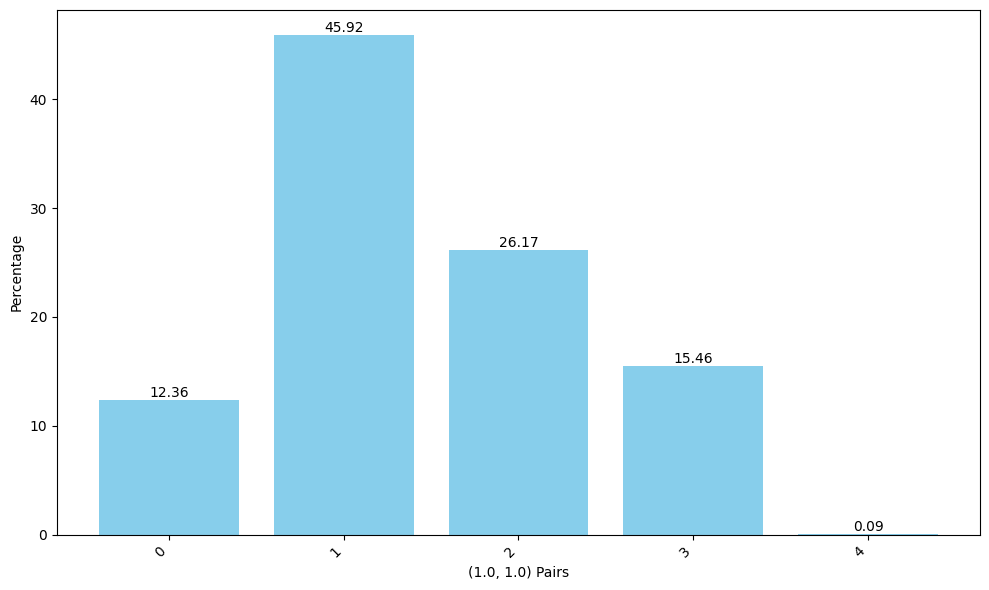

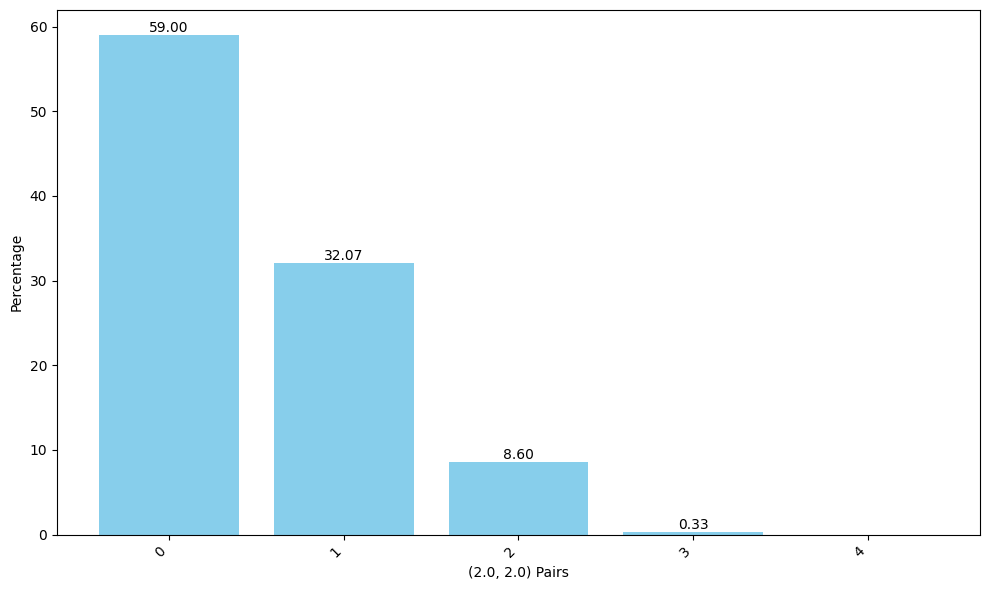

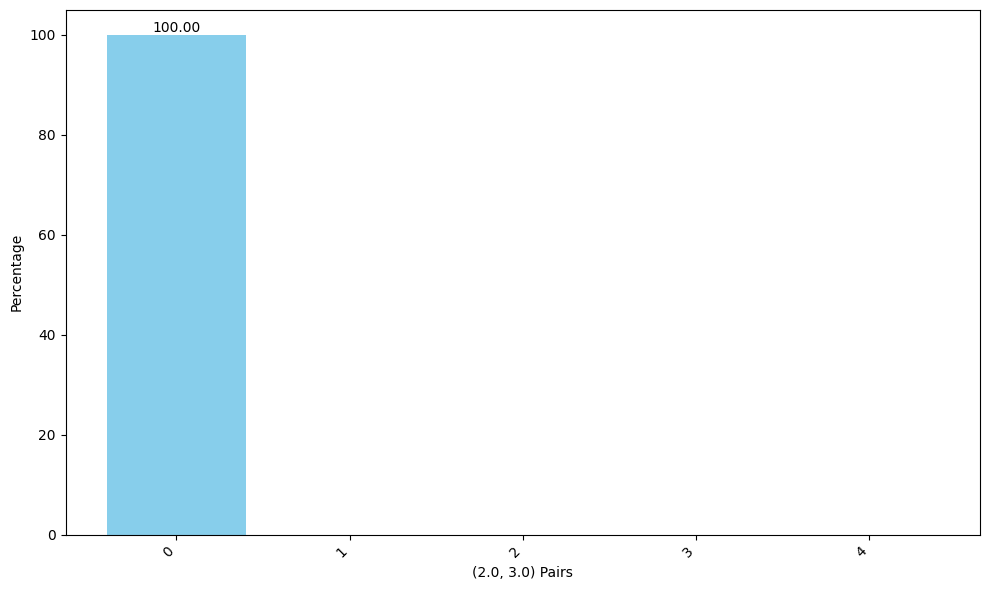

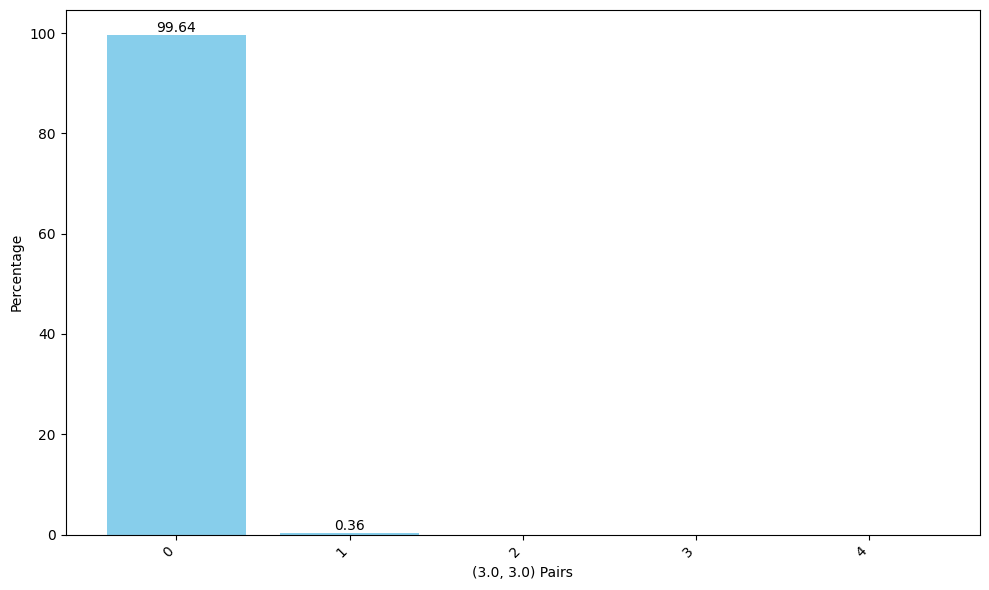

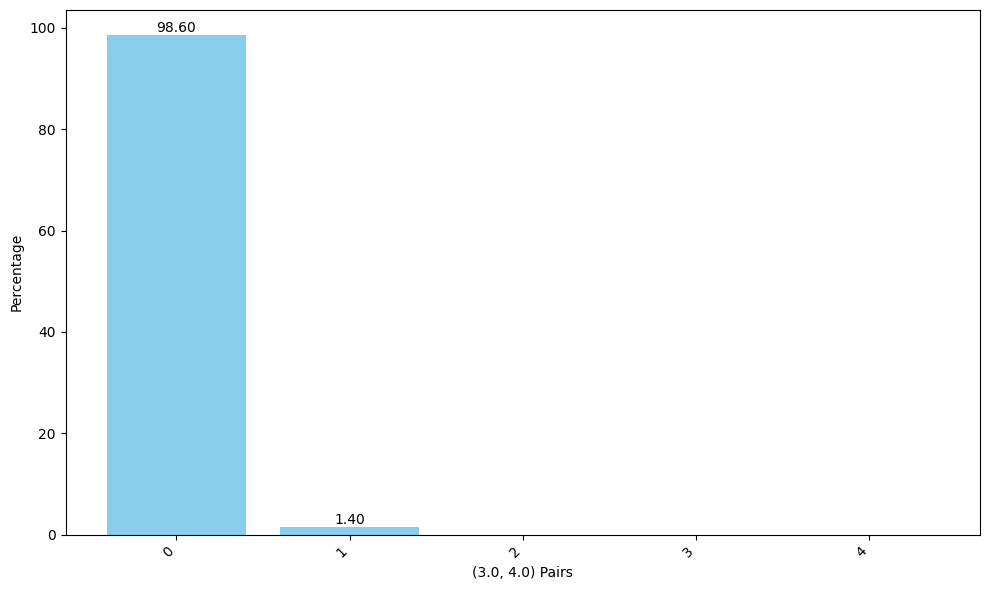

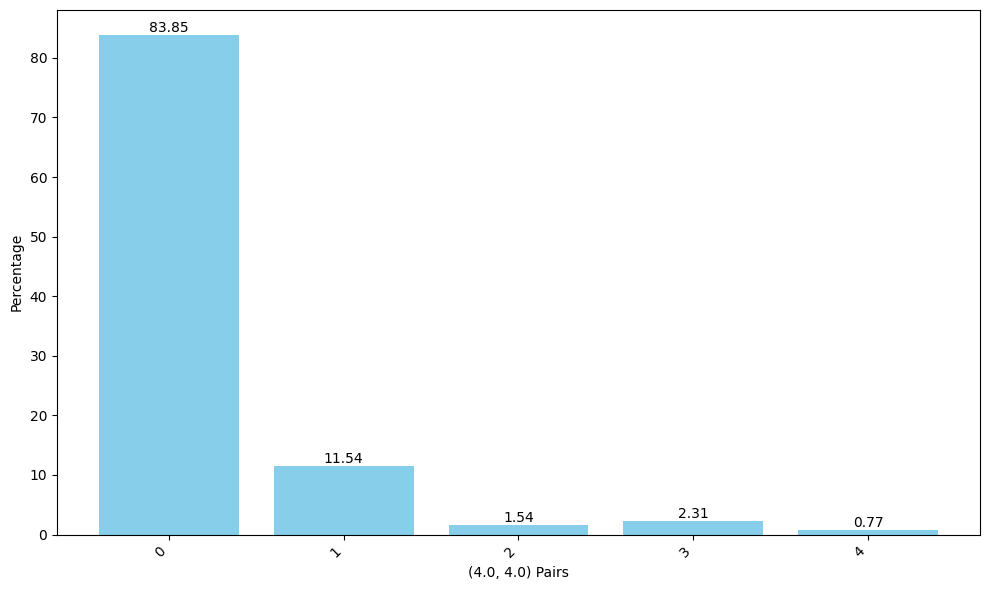

In [10]:
reporting(first_y_test, second_y_test, predicted_labels)

In [11]:
unique_elements, counts = np.unique(pred, return_counts=True)
for element, count in zip(unique_elements, counts):
    print("Phần tử", element, "xuất hiện", count, "lần")


Phần tử 0 xuất hiện 8813 lần
Phần tử 1 xuất hiện 1566 lần
Phần tử 2 xuất hiện 1216 lần
Phần tử 3 xuất hiện 635 lần
Phần tử 4 xuất hiện 3664 lần


In [12]:
len(first_y)

79466